In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import scipy.stats, scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('/home/hugo/Thèse/styles.mplstyle')
import seaborn as sns
import identification.dataset
import random
%matplotlib widget

In [4]:
config = {
    'frame_size': 2048,
    'hop_ratio': 1,
    'n_coeff': 60,
    'sr': 10000,
    'sample_duration': 30,
    'feature': 'MFCC_welch',
    # 'clf': sklearn.neighbors.KNeighborsClassifier(),
    # 'clf__n_neighbors': 21,
    # 'clf__p': 1,
    # 'clf__weights': 'distance',
    'clf': sklearn.svm.SVC(),
    'clf__decision_function_shape': 'ovr',
    'clf__kernel': 'linear',
    'clf__C': 1.0,
}

In [5]:
# data = pd.read_pickle('../data/processed/dataset_bilbao.pkl')
# data = data[data.type.isin(['scale', 'free']) & (data.player != 15)]
# data = data[(data.player.isin([1,2,3,4]))]

data = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
data = data[(data.violin.isin(['A', 'B', 'C']))]

features = identification.dataset.get_dataset(config, data)

100%|██████████| 1183/1183 [00:39<00:00, 29.96it/s]


## Distances Histogram

In [45]:
a = np.vstack(features.features)

b = scipy.spatial.distance.cdist(a, a, 'euclidean')
all_distances = b[np.triu_indices(len(b), k=1)]

def group_distances(features, column):
    values = features[column].unique()

    distances = []
    for value in values:
        points = features[features[column] == value]
        a = np.vstack(points.features)
        b = scipy.spatial.distance.cdist(a, a, 'euclidean')
        distances.append(b[np.triu_indices(len(b), k=1)])

    return np.hstack(distances)

intra_violin_distances = group_distances(features, 'violin')
intra_player_distances = group_distances(features, 'player')

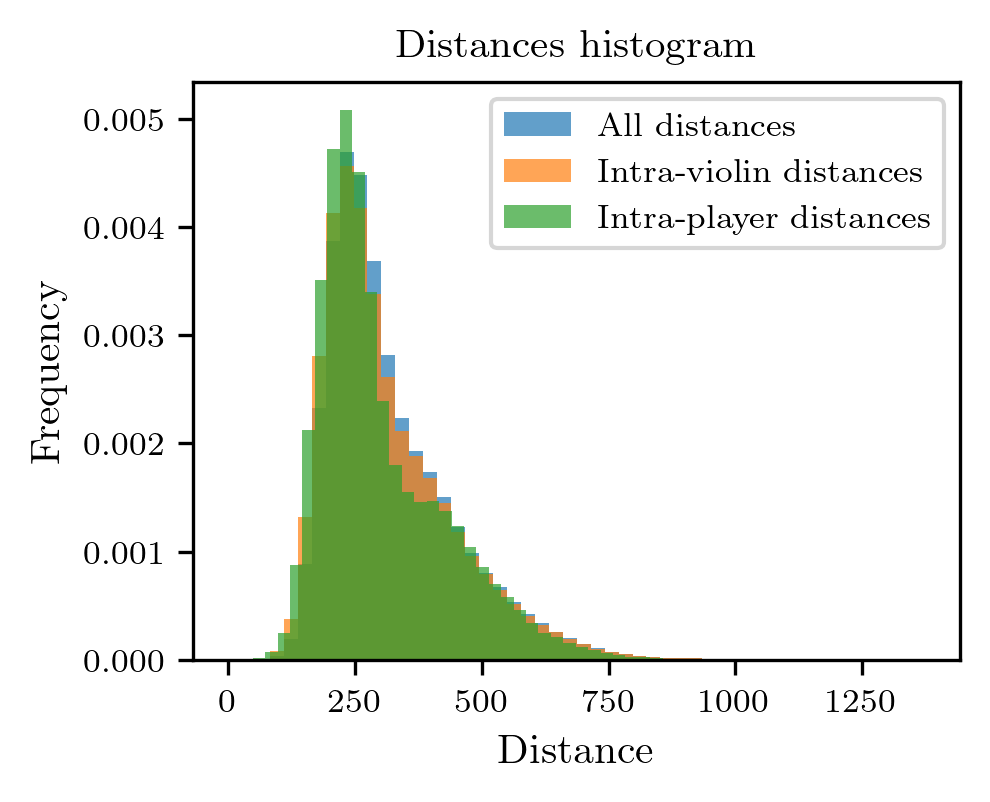

In [48]:
fig, ax = plt.subplots()
ax.hist(all_distances, bins=50, density=True, label='All distances', alpha=.7)
ax.hist(intra_violin_distances, bins=50, density=True, label='Intra-violin distances', alpha=.7)
ax.hist(intra_player_distances, bins=50, density=True, label='Intra-player distances', alpha=.7)
ax.set_title('Distances histogram')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

In [9]:
a = np.vstack(features.features)
print(a.shape)
b = np.abs((a[:, np.newaxis, :] - a[np.newaxis, :, :])**2)
i, j = np.triu_indices(b.shape[0], k=1)
all_distances = b[i, j, :]

def group_distances(features, column):
    values = features[column].unique()
    print(values)

    distances = []
    for value in values:
        points = features[features[column] == value]
        a = np.vstack(points.features)
        b = np.abs((a[:, np.newaxis, :] - a[np.newaxis, :, :])**2)
        i, j = np.triu_indices(b.shape[0], k=1)
        all_distances = b[i, j, :]
        distances.append(all_distances)

    return np.vstack(distances)

intra_violin_distances = group_distances(features, 'violin')
intra_player_distances = group_distances(features, 'player')

(1742, 60)
['B' 'C' 'A']
['Paul' 'Renato' 'Areski' 'Félix' 'Céleste' 'SMD' 'Hélène' 'Clara'
 'Norimi' 'Fanton' 'Lucie' 'Eugénie' 'Antonin']


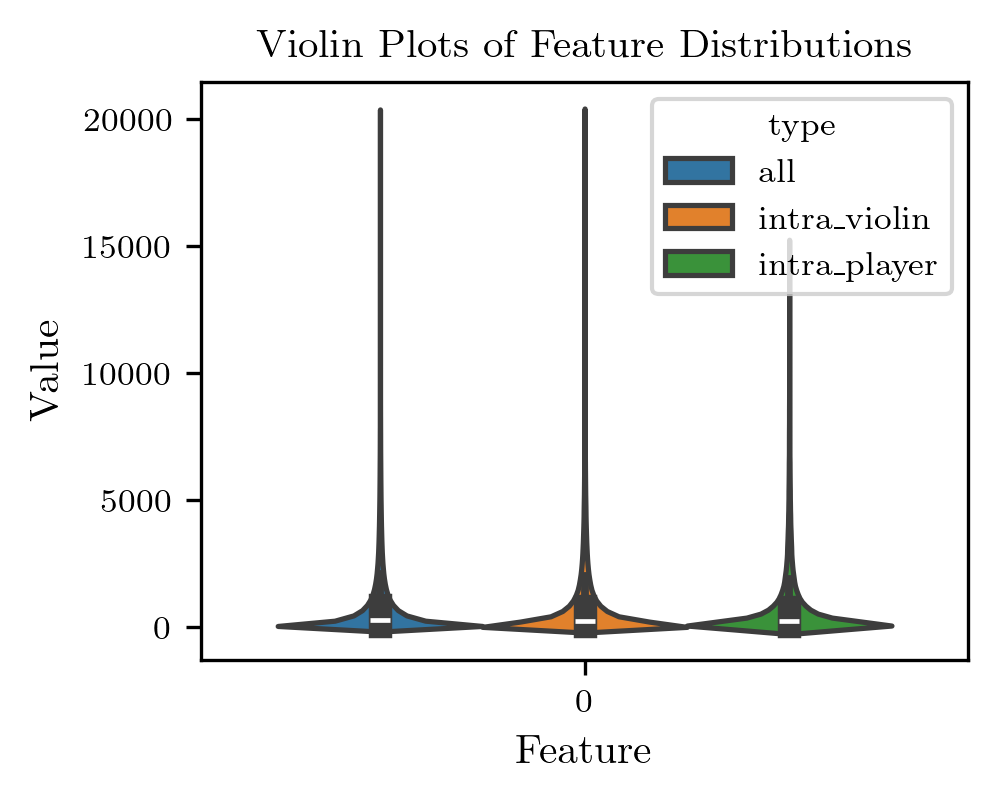

In [30]:
ind = [50]
test = all_distances[:, ind]

df = pd.DataFrame(test)
df['type'] = 'all'

df_v = pd.DataFrame(intra_violin_distances[:, ind])
df_v['type'] = 'intra_violin'

df_p = pd.DataFrame(intra_player_distances[:, ind])
df_p['type'] = 'intra_player'

df = pd.concat([df, df_v, df_p])
df = df.melt(id_vars=['type'], var_name="Feature", value_name="Value")

plt.figure()
sns.violinplot(data=df, x="Feature", y="Value", hue='type')
plt.title("Violin Plots of Feature Distributions")
plt.show()